In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import pydicom
from skimage import io

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
42186,00010847_004.png,Fibrosis|Pleural_Thickening,4,10847,66,F,PA,2048,2500,0.168,0.168,NaN
38420,00010043_006.png,No Finding,6,10043,35,M,PA,2992,2991,0.143,0.143,NaN
75449,00018519_001.png,No Finding,1,18519,74,M,AP,2500,2048,0.168,0.168,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1758,00009297_013.png,Effusion,13,9297,066Y,M,PA,2500,2048,0.168,0.168
1667,00008701_049.png,Consolidation,49,8701,047Y,F,AP,2500,2048,0.168,0.168
5591,00030635_007.png,Atelectasis|Effusion|Infiltration,7,30635,050Y,F,AP,3056,2544,0.139,0.139


(array([63340., 48780.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

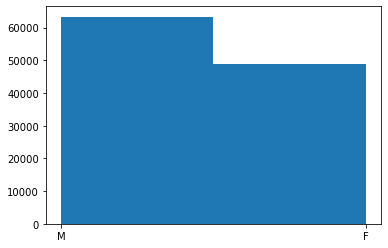

In [4]:
## EDA

# Patient Gender Distribution
plt.hist(all_xray_df['Patient Gender'], bins=2)

In [5]:
# Ratio of M:F
63340/48780

1.2984829848298483

### The above plot shows the gender distribution of the entire dataset. There is a M:F ratio of 1.3.

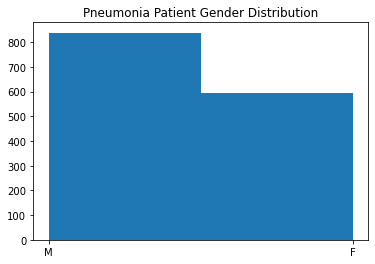

In [6]:
# Pneumonia Patient Gender Distribution
pne = all_xray_df.loc[all_xray_df['Finding Labels'].str.contains('Pneumonia')]
plt.hist(pne['Patient Gender'], bins=2)
plt.title('Pneumonia Patient Gender Distribution')
plt.savefig('gender.png')

In [7]:
# Ratio of M:F 
838/593

1.4131534569983137

### The above plot shows the gender distribution of patients in the dataset with pneumonia. There is a M:F ratio of 1.4.

Text(0.5, 1.0, 'Patient Age Distribution for the Entire Dataset, Disregarding Outliers')

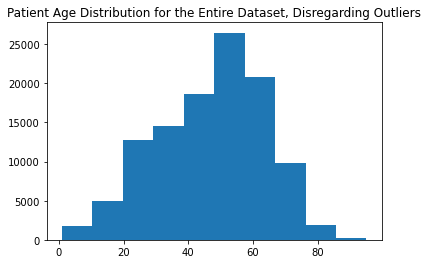

In [8]:
# Patient Age Distribution

## Since there are some outliers for patient age, let us remove them from our visualization
_plot = all_xray_df['Patient Age'].loc[all_xray_df['Patient Age'].astype(int) < 110]

plt.hist(_plot)
plt.title('Patient Age Distribution for the Entire Dataset, Disregarding Outliers')

In [9]:
_plot.describe()

count    112104.000000
mean         46.872574
std          16.598152
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

In [10]:
# Number of outliers for age
len(all_xray_df['Patient Age'].loc[all_xray_df['Patient Age'].astype(int) >= 110])

16

### The above plot describes the Patient Age Distribution for the entire data set. The mean is 46.9 with a std of 16.6. There are 16 outliers with age above 110.

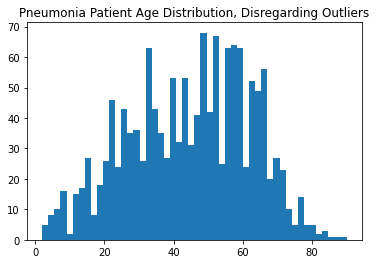

In [11]:
# Patient Age Distribution for patients with pneumonia
pne = all_xray_df.loc[all_xray_df['Finding Labels'].str.contains('Pneumonia')]
_plot = pne['Patient Age'].loc[pne['Patient Age'].astype(int) < 110]
plt.hist(_plot, bins=50)
plt.title('Pneumonia Patient Age Distribution, Disregarding Outliers')
plt.savefig('age.png')

In [12]:
_plot.describe()

count    1430.000000
mean       44.670629
std        17.639098
min         2.000000
25%        31.000000
50%        46.000000
75%        59.000000
max        90.000000
Name: Patient Age, dtype: float64

In [13]:
len(pne['Patient Age'].loc[pne['Patient Age'].astype(int) >= 110])

1

In [14]:
pne['Patient Age'].loc[pne['Patient Age'].astype(int) >= 110]

20852    412
Name: Patient Age, dtype: int64

### The above plot describes the Patient Age Distribution for Penumonia Patients. The mean is 44.6 with a std of 17.6. There is 1 outlier with an age of 412.

(array([67310., 44810.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

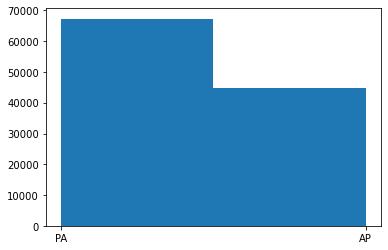

In [15]:
# View Position Distribution
plt.hist(all_xray_df['View Position'], bins=2)

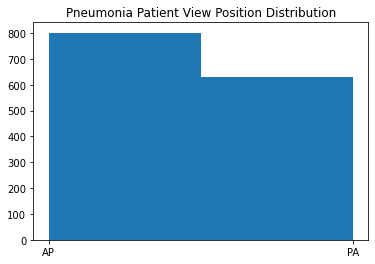

In [16]:
# View Position Distribution for Pneumonia Patients
pne = all_xray_df.loc[all_xray_df['Finding Labels'].str.contains('Pneumonia')]
plt.hist(pne['View Position'], bins=2)
plt.title('Pneumonia Patient View Position Distribution')
plt.savefig('view.png')

### The above plots show the view position distribution for the entire dataset and then just the pneumonia patients. There are only two views in the dataset, with 'AP' being more common for the Pneumonia Patients.

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


[Text(0, 0.5, 'Number of Images with Label')]

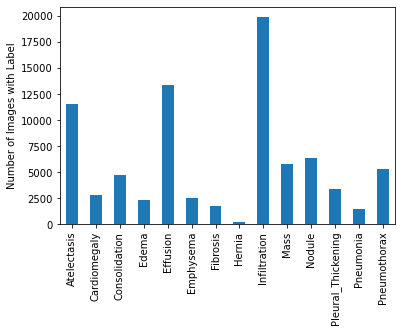

In [17]:
# Finding Labels Distribution
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

# Drop the rows with No Finding
to_plot = all_xray_df[all_labels].drop('No Finding',axis=1)

ax = to_plot.sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

### Infiltration is the most common label, with Effusion and Atelectasis following it. There is a small sample of patients with Pneumonia in our dataset.

In [18]:
# Number of pneumonia cases
pneumonia_cases = to_plot['Pneumonia'].sum()
print(f'Number of pneumonia cases: {pneumonia_cases}')

Number of pneumonia cases: 1431.0


In [19]:
# Number of non-pneumonia cases
non_pneumonia = len(to_plot) - pneumonia_cases
print(f'Number of non-pneumonia cases: {non_pneumonia}')

Number of non-pneumonia cases: 110689.0


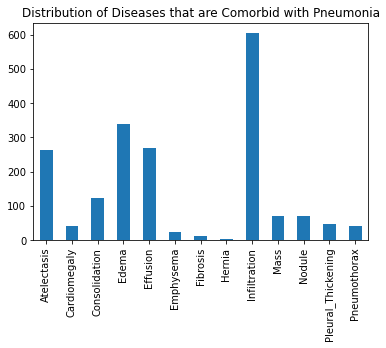

In [21]:
# The distribution of other diseases that are comorbid with pneumonia
comorbidity = to_plot[to_plot.Pneumonia==1]
# Drop pneumonia from dataframe
comorbidity = comorbidity.drop(['Pneumonia'],axis=1)
comorbidity.sum().plot(kind='bar', title='Distribution of Diseases that are Comorbid with Pneumonia')

### Infiltration is the most common disease to be comorbid with Pneumonia.

In [22]:
# Number of disease per patient
number_diseases = []
for row in to_plot.iterrows():
    number_diseases.append(sum(row[1].values))
mySeries = pd.Series(number_diseases)

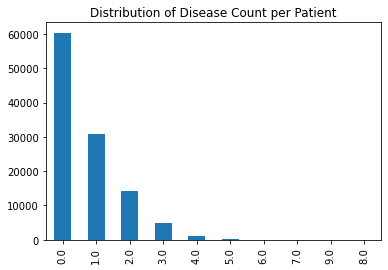

In [23]:
mySeries.value_counts().plot(kind='bar',title='Distribution of Disease Count per Patient')

### The majority of the patients that had a disease only had one.

In [24]:
# Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) 
# and compare distributions across diseases.
df = sample_df
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4821,00025360_002.png,Effusion|Emphysema|Infiltration,2,25360,058Y,F,AP,3056,2544,0.139000,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4406,00021782_018.png,No Finding,18,21782,035Y,F,PA,1697,1960,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4558,00022776_013.png,No Finding,13,22776,060Y,F,AP,3056,2496,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
data_sample = pd.read_csv('sample_labels.csv')
data_sample_paths = {os.path.basename(x): x for x       
                     in glob(os.path.join('/data','images*', '*', 
                     '*.png'))}
data_sample['path'] = data_sample['Image Index'].map(data_sample_paths.get)

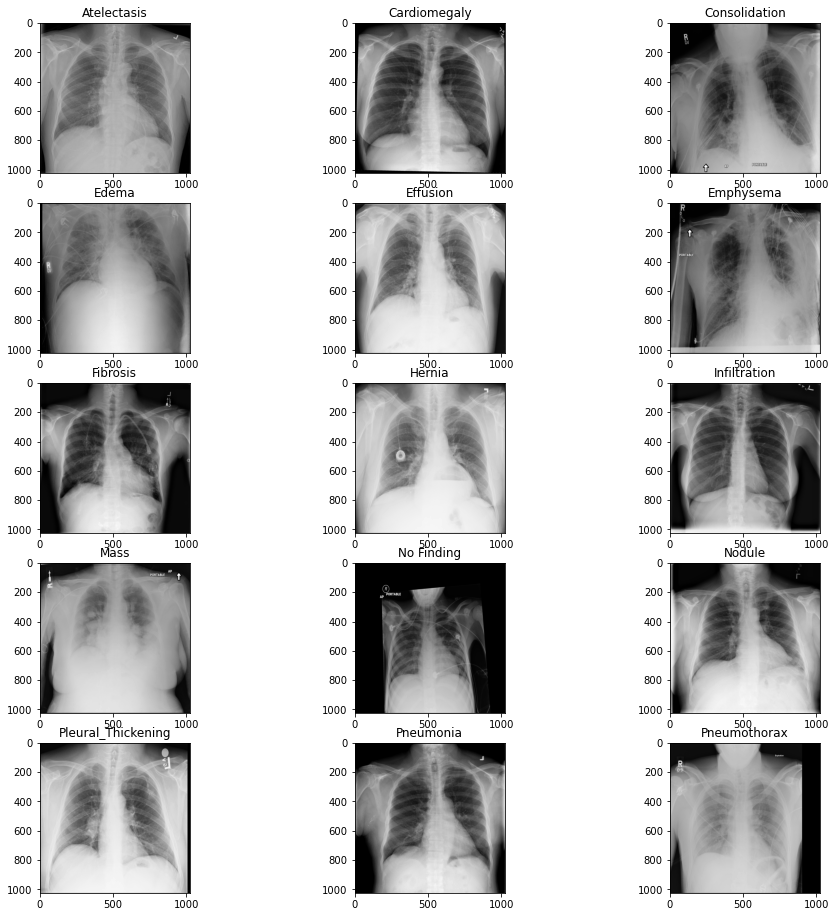

In [26]:
fig, m_axs = plt.subplots(5,3, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = []
to_show = pd.DataFrame()
for c_label in all_labels:
    data = data_sample.loc[data_sample['Finding Labels'] == c_label].sample(1)
    to_show = to_show.append(data)
imgs = to_show['path']
ind=0    
for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(to_show.iloc[ind]['Finding Labels'])
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    new_img = img.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    ax.imshow(new_img,cmap='gray')
    ax.set_title(to_show.iloc[ind]['Finding Labels'])
    ind=ind+1

### These images will give us an idea of what our model will be processing to detect pneumonia.

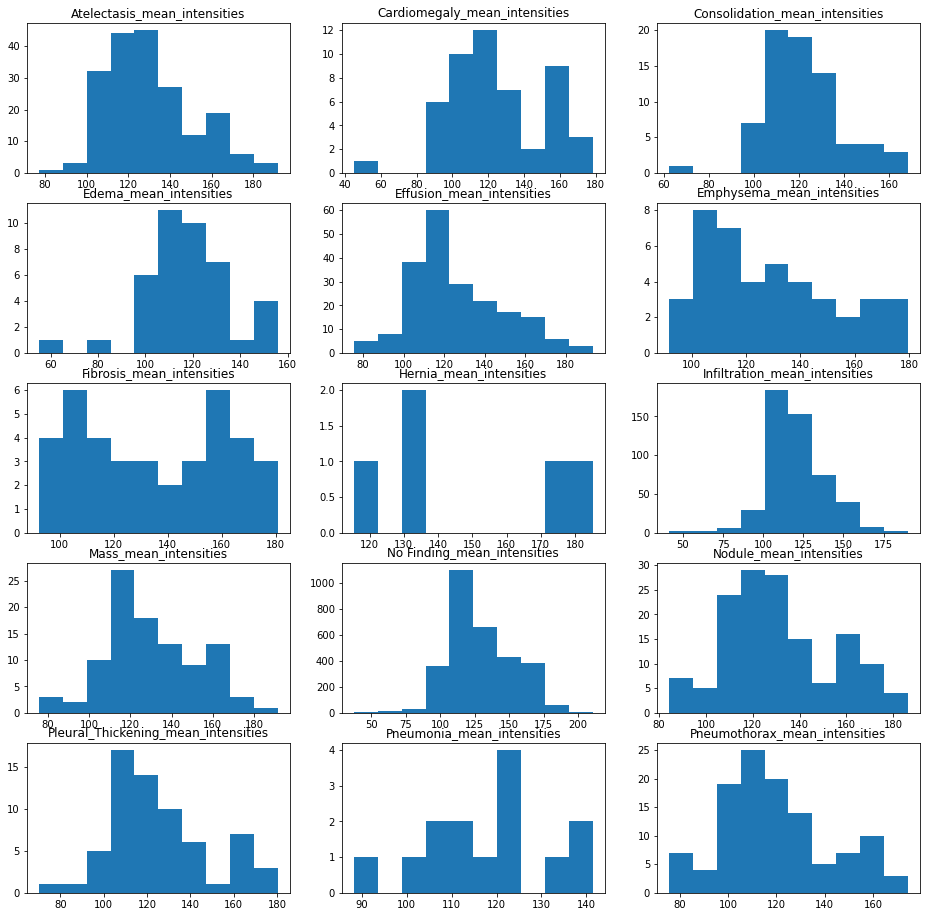

In [27]:
fig, m_axs = plt.subplots(5,3, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = data_sample['path']
ind=0

for c_label, ax in zip(all_labels, m_axs):
    
    data = data_sample.loc[data_sample['Finding Labels'] == c_label]
    std_intensities = []
    mean_intensities = []
    for img in data['path']:
        img = io.imread(img)
        mean_intensity = np.mean(img)
        mean_intensities.append(mean_intensity)
            
    mean_label = c_label+'_mean_intensities'
    ax.set_title(mean_label)
    ax.hist(mean_intensities)

### These plots show how the mean_intensities vary across diseases. Notice how the distribution for Pneumonia is unique. 

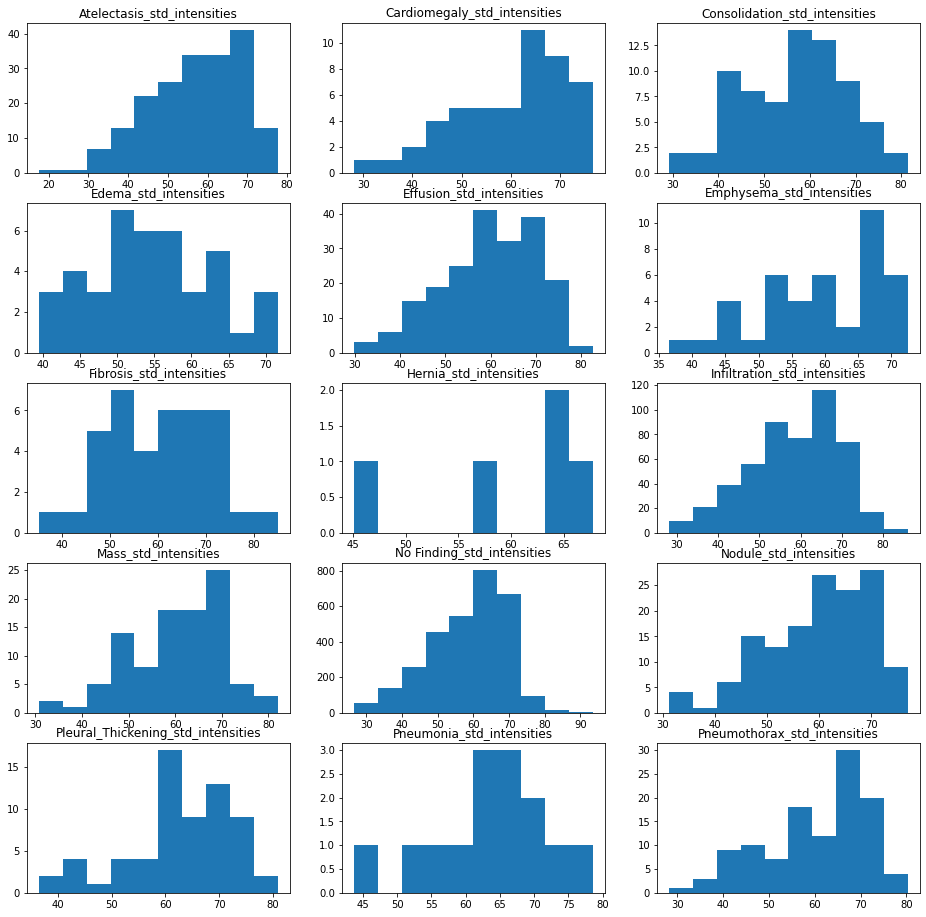

In [28]:
fig, m_axs = plt.subplots(5,3, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = data_sample['path']
ind=0

for c_label, ax in zip(all_labels, m_axs):
    
    data = data_sample.loc[data_sample['Finding Labels'] == c_label]
    std_intensities = []
    mean_intensities = []
    for img in data['path']:
        img = io.imread(img)
        std_intensity = np.std(img)
        std_intensities.append(std_intensity)
            
    std_label = c_label+'_std_intensities'
    ax.set_title(std_label)
    ax.hist(std_intensities)

### These plots show how the std_intensities vary across diseases. Notice how the distribution for Pneumonia is unique. 

# Conclusion:

## The model will utilize the intensity distributions to predict the presence of Pneumonia in patients.